In [3]:
from supervised.automl import AutoML
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import pickle


## 1. Models tuned

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

### 1.1 Decision Tree

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
def decision_tree(X_train,X_test,y_train,y_test):
    clf = DecisionTreeRegressor()
    clf = clf.fit(X_train, y_train)
    return clf, np.sqrt(mean_squared_error(y_test, clf.predict(X_test)))


### 1.2 Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor
def random_forest(X_train,X_test,y_train,y_test):
    #hyperparameter-tuning
    # Number of trees in random forest
    n_estimators = [100, 200, 300, 1000]

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(50, 100,10)]

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    grid = {'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap
            }

    clf = RandomForestRegressor()
    clf_cv = RandomizedSearchCV(estimator = clf, param_distributions = grid, cv = 5, random_state=42)
    # Fit the random search model
    clf_cv=clf_cv.fit(X_train, y_train)
    return clf_cv, np.sqrt(mean_squared_error(y_test, clf_cv.predict(X_test)))

### 1.3 Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression

def linear_regression(X_train, X_test, y_train, y_test):
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    return clf, np.sqrt(mean_squared_error(y_test, clf.predict(X_test)))

### 1.4 Neural Networks

In [21]:
from sklearn.neural_network import MLPRegressor
import numpy as np

def neural_network(X_train,X_test,y_train,y_test):
    # Create the random grid
    grid = [
    {'solver': ['sgd'],
     'learning_rate_init': [0.000001],
     'max_iter': [10000],
     'hidden_layer_sizes': [(50,40,30),(30, 30),(10,10,10)],
     'activation': ['logistic', 'relu'],
     'alpha': [0.0001, 0.001, 0.005],
     }
]
    clf = MLPRegressor()
    clf_cv = RandomizedSearchCV(estimator = clf, param_distributions = grid, cv = 5, random_state=42)
    clf_cv=clf_cv.fit(X_train,y_train)
    return clf_cv,np.sqrt(mean_squared_error(y_test, clf_cv.predict(X_test)))

## 2. F1

In [42]:
def run_autoML(X_train,X_test,y_train,y_test):
    automl = AutoML(eval_metric='rmse', explain_level=1, top_models_to_improve=4, random_state=2, optuna_verbose=False)
    automl.fit(X_train, y_train)
    # compute the MSE on test data
    predictions = automl.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, predictions))

In [35]:
dataset = pd.read_csv('ml_dataset.csv')
dataset_cleaned  = dataset[dataset.algo != 'Ensemble']
dataset_cleaned = dataset_cleaned.drop(columns=['did'])
dataset_cleaned['consumption']=dataset_cleaned['time']*dataset_cleaned['TDP']

In [62]:
algos=dataset_cleaned['algo'].unique()
list_models=[{"name":"Decision Tree", "clf":decision_tree}, {"name":"Random Forest", "clf":random_forest},{"name":"Linear Regression",  "clf":linear_regression}, {"name":"Nerual Network", "clf":neural_network}]
names=[x['name'] for x in list_models]
rmse_per_algo=[]
for algo in algos:
    clf=[]
    print(f'-------------DATASET {algo}--------------')
    df=dataset_cleaned[dataset_cleaned['algo']==algo]
    df=dataset_cleaned.drop(columns=['algo','country','TDP','consumption','time'])
    df=df.dropna()
    #log scaling for heavy-tailed distributions
    for i in df.columns:
        if i!='F1':
            df[i]=np.log(1+df[i])
    X=df.loc[:,df.columns!='F1']
    y=df['F1']
    #selectin 7 features with highest mutual_information
    X = SelectKBest(mutual_info_regression, k=7).fit_transform(X, y)
    #Train-Test splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    run_autoML(X_train,X_test,y_train,y_test)
    rmse_list=[]
    clf_list=[]
    #models training
    for model in list_models:
        clf,rmse=model['clf'](X_train,X_test, y_train,y_test)
        rmse_list.append(rmse)
        clf_list.append(clf)
    data={'Model':names, 'RMSE':rmse_list}
    df_plot=pd.DataFrame(data)
    rmse_per_algo.append(rmse_list)
    #plotting
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x="Model", y="RMSE", data=df_plot)
    filename='_'.join(algo.split())
    plt.savefig(f'./plots/F1_model_{filename}.png')
    rmse_per_algo.append(rmse_list)
    #saving best model
    pickle.dump(clf_list[np.argmin(np.array(rmse_list))], open(f'./models/F1_model_{filename}.sav', 'wb'))
    print(f'Min rmse:{np.min(rmse_list)}, Algorithm:{names[np.argmin(np.array(rmse_list))]}')
        

-------------DATASET Decision Tree--------------
AutoML directory: AutoML_2
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.247503 trained in 0.33 seconds
2_DecisionTree rmse 0.217094 trained in 8.85 seconds
3_Linear rmse 0.228781 trained in 0.36 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.180011 trained in 1.98 seconds
5_Default_NeuralNetwork rmse 0.216769 trained in 0.59 seconds
6_Default_RandomForest rmse 0.207811 trained in 1.57 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.17836 trained in 0.22 seconds
AutoML fit time: 18.25 seconds
AutoML best model: Ensemble
-------------DATASET Linear--------------
AutoML dire

## 3. Consumption

In [51]:
dataset = pd.read_csv('ml_dataset.csv')
dataset_cleaned  = dataset[dataset.algo != 'Ensemble']
dataset_cleaned = dataset_cleaned.drop(columns=['did'])
dataset_cleaned['consumption']=dataset_cleaned['time']*dataset_cleaned['TDP']

-------------DATASET Decision Tree--------------
Min rmse:216.61307644319174, Algorithm:Random Forest
-------------DATASET Linear--------------
Min rmse:216.42030511147144, Algorithm:Random Forest
-------------DATASET Neural Network--------------
Min rmse:215.3778445932086, Algorithm:Random Forest
-------------DATASET Random Forest--------------
Min rmse:216.69340258192236, Algorithm:Random Forest


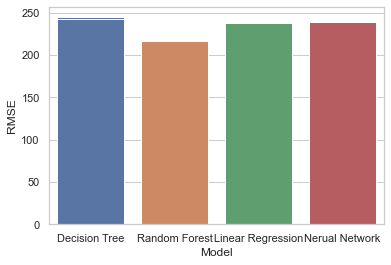

In [59]:
algos=dataset_cleaned['algo'].unique()
list_models=[{"name":"Decision Tree", "clf":decision_tree}, {"name":"Random Forest", "clf":random_forest},{"name":"Linear Regression",  "clf":linear_regression}, {"name":"Nerual Network", "clf":neural_network}]
names=[x['name'] for x in list_models]
rmse_per_algo=[]
for algo in algos:
    print(f'-------------DATASET {algo}--------------')
    df=dataset_cleaned[dataset_cleaned['algo']==algo]
    df=dataset_cleaned.drop(columns=['time','algo','country','TDP','F1'])
    df=df.dropna()
    #removing outliers in column consumption
    k=0.2
    Q1 = df['consumption'].quantile(0.25)
    Q3 = df['consumption'].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df['consumption'] < (Q1 - k * IQR)) |(df['consumption'] > (Q3 + k * IQR)))]
    #log scaling for heavy-tailed distributions
    for i in df.columns:
        if i!='consumption':
            df[i]=np.log(1+df[i])
    X=df.loc[:,df.columns!='consumption']
    y=df['consumption']
    #selectin 7 features with highest mutual_information
    X = SelectKBest(mutual_info_regression, k=7).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    # run_autoML(X_train,X_test,y_train,y_test)
    rmse_list=[]
    clf_list=[]
    for model in list_models:
        clf,rmse=model['clf'](X_train,X_test, y_train,y_test)
        rmse_list.append(rmse)
        clf_list.append(clf)
    data={'Model':names, 'RMSE':rmse_list}
    #plotting
    df_plot=pd.DataFrame(data)
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x="Model", y="RMSE", data=df_plot)
    filename='_'.join(algo.split())
    plt.savefig(f'./plots/consumption_model_{filename}.png')
    rmse_per_algo.append(rmse_list)
    #save best model
    pickle.dump(clf_list[np.argmin(np.array(rmse_list))], open(f'./models/consumption_model_{filename}.sav', 'wb'))
    print(f'Min rmse:{np.min(rmse_list)}, Algorithm:{names[np.argmin(np.array(rmse_list))]}')
    

In [60]:
dataset_cleaned['consumption'].describe()

count      2871.000000
mean       1406.837339
std        4808.966857
min         205.000000
25%         517.500000
50%         760.000000
75%        1237.500000
max      146717.500000
Name: consumption, dtype: float64

<AxesSubplot:>

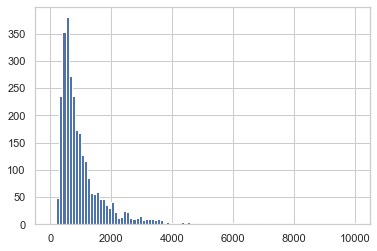

In [31]:
dataset_cleaned['consumption'].hist(bins=100,range=[0, 10000])